#This script uses opencv-python, which depend on libgl1-mesa-dev 
#if you haven't installed, please install like this:
sudo apt-get update
sudo apt-get install libgl1-mesa-dev
pip install opencv-python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib

#乱数の固定
import os
import random
# TF RNG
from tensorflow.python.framework import random_seed


os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 42
random_seed.set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#ベースモデル
BASE_MODEL="VGG16"

#バッチサイズと画像サイズの設定
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

#読み込むデータのディレクトリを指定（このフォルダの下に分類ごとにフォルダ分けして保存してあること）
data_root = pathlib.Path("./Image/Fruits")
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
#Load Data as dataset
# Train:Validation:Test = 7:1.5:1.5

ValidateionSplitRate=0.3

train_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',#intの場合、モデルにはloss='sparse_categorical_crossentropy'を設定する。別のcategoricalはダメ。
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="training",#これがトレーニング用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
validation_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="validation",#これがValidation用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
class_names = train_dataset.class_names
print("class_names=",class_names)

Found 759 files belonging to 5 classes.
Using 532 files for training.
Found 759 files belonging to 5 classes.
Using 227 files for validation.
class_names= ['apple_braeburn', 'apple_golden_delicious', 'apple_topaz', 'peach', 'pear']


2021-11-10 02:39:40.868903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9570 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:65:00.0, compute capability: 8.6


In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 4


In [5]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [6]:
from keras.models import load_model
model2 = load_model("FruitsSorter2CategoryNoInputTensor"+BASE_MODEL+".tf")

In [7]:
x,y = test_dataset.as_numpy_iterator().next()
tx=tf.reshape(x[0], [-1,IMG_SIZE[0], IMG_SIZE[1],3])

2021-11-10 02:39:47.796813: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
#Try model
pred=model2(tx)
pred_id=np.argmax(pred)
name=class_names[pred_id]
pred_array=tf.reshape(pred, (-1))
confi=pred_array[pred_id].numpy()
print(name,"\n",confi)

2021-11-10 02:39:49.619088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


apple_golden_delicious 
 0.9980987


2021-11-10 02:39:51.329144: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
import cv2

def overlay_heatmap(img_src_tensor, heatmap, alpha=0.5):
    #カラー画像(1,224,224,3)、ヒートマップ（小数点）、ブレンド率
    size=img_src_tensor.shape
    img_underneath=tf.reshape(img_src_tensor,[size[1],size[2],3])#
    img_underneath=img_underneath.numpy().astype('uint8')

    # Rescale heatmap to a range 0-255
    heatmap_scaled = np.uint8(255 * heatmap)
    heatmap_fit=cv2.resize(heatmap_scaled, dsize=(size[1],size[2]))
    heatmap_color = cv2.applyColorMap(heatmap_fit, cv2.COLORMAP_JET)

    
    img_3dim_bgr=cv2.cvtColor(img_underneath,cv2.COLOR_BGR2RGB)
    blended = cv2.addWeighted(img_3dim_bgr, alpha, heatmap_color, 1 - alpha, 0)
    blended_dst=cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    return blended_dst

In [10]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer

    with tf.GradientTape() as tape: 
        last_conv_layer_output, preds = grad_model(img_array)#img_arrayは毎回まったく同じ数値
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    #print(last_conv_layer_output[:,:,:,0][0][1].numpy())
    grads = tape.gradient(class_channel, last_conv_layer_output)

    #print(lastconv100[:,:,:,0])


    #print(grads)#実行のたびに値が変わる！？

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)


    #分類名と確度の取得
    pred_id = tf.argmax(preds[0])
    name=class_names[pred_id]
    pred_array=tf.reshape(pred, (-1))
    confi=pred_array[pred_id].numpy()
    print(name,", ",confi)

    return heatmap.numpy()

apple_golden_delicious ,  0.9980987


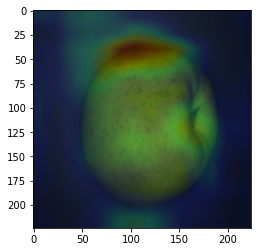

apple_golden_delicious ,  0.9980987


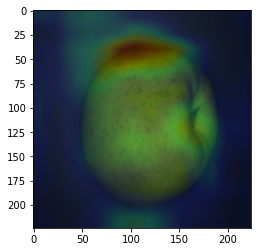

apple_golden_delicious ,  0.9980987


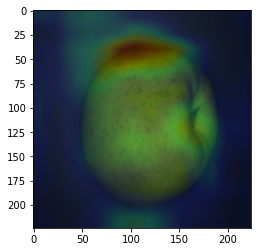

apple_golden_delicious ,  0.9980987


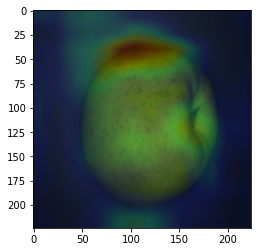

apple_golden_delicious ,  0.9980987


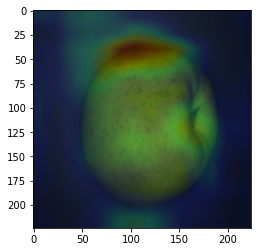

In [11]:
#heatmap changes each time in spite of input image and its prediction is same...
model2.layers[-1].activation=None#サンプルより
for i in range(5):
    heatmap2 = make_gradcam_heatmap(tx, model2, "block5_conv3")
    #conv5_block16_concat conv5_block16_2_conv
    overlayed = overlay_heatmap(tx, heatmap2, 0.8)
    plt.imshow(overlayed)
    plt.pause(0.001)